In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)
%load_ext skip_kernel_extension

In [2]:
import keras_tuner as kt


In [3]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
tf.random.set_seed(2022)

In [4]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = False

## Loading Data

In [5]:
combined_df = pd.read_csv("extended_preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [6]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,6378.0,25385.0,65.41,28251.0,2866.0,2866.0,1,1,0,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,5890.0,24382.0,64.92,27818.0,3436.0,6302.0,1,1,0,1
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,5461.0,22734.0,64.48,26796.0,4062.0,10364.0,1,1,0,2
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,5238.0,21286.0,59.32,25223.0,3937.0,14301.0,1,1,0,3
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,4935.0,20264.0,56.04,24620.0,4356.0,18657.0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,3113.0,30653.0,77.02,26415.0,-4238.0,-2062312.5,12,31,0,19
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,3288.0,29735.0,76.16,25213.0,-4522.0,-2066834.5,12,31,0,20
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,3503.0,28071.0,74.30,23987.0,-4084.0,-2070918.5,12,31,0,21
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,3586.0,25801.0,69.89,22748.0,-3053.0,-2073971.5,12,31,0,22


# Encode- Decoder + LSTM

Scale the input data

In [7]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [8]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-28'
feature = 'total load actual'
namespace= 'MS_EDLSTM_WL5'
modeltype = 'EDLSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [9]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24*14,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24*14,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24*14,24,32)


In [10]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17152, 336, 28) (17152, 24)
(1024, 336, 28) (1024, 24)
(256, 336, 28) (256, 24)


Define LSTM Model

In [11]:
def build_model_ED_LSTM(hp):
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential()
    # Encoder
    model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,input_shape=(None, n_features), stateful=False)) 
    model.add(layers.BatchNormalization())
    
    for i in range(hp.Int('n_layers',1,4,1)):
        model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
        model.add(layers.BatchNormalization())
      
    model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=False, stateful=False)) 
    model.add(layers.BatchNormalization())  
    
    # Repeat Vector
    model.add(layers.RepeatVector(n_outputs))
    
    # Decoder
    model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
    
    model.add(layers.BatchNormalization())

    for i in range(hp.Int('n_layers',1,4,1)):
        model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
        model.add(layers.BatchNormalization())

    model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())

    # End
    model.add(layers.TimeDistributed(layers.Dense(hp.Int('Neurons',min_value=32,max_value=96,step=16), kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal")))
    
    model.add(layers.TimeDistributed(layers.LeakyReLU(alpha=hp.Float('alpha',min_value=0.1,max_value=0.5,step=0.1))))                     
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.Dense(1)))                     
                
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [12]:
tuner = kt.RandomSearch(
    build_model_ED_LSTM,
    objective='val_loss',
    max_trials=5,
    executions_per_trial = 2,
    directory = "./hpt_ED_LSTM/",
    project_name="WL_HPT")
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./hpt_ED_LSTM/WL_HPT\oracle.json
INFO:tensorflow:Reloading Tuner from ./hpt_ED_LSTM/WL_HPT\tuner0.json
Search space summary
Default search space size: 3
Neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
alpha (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [13]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [14]:
num_epochs = 150
batch_size = 32

In [15]:
# tuner.search(data_x_train,data_y_train,epochs=150,validation_data=(data_x_val,data_y_val),batch_size=batch_size,callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

In [16]:
tuner.results_summary()

Results summary
Results in ./hpt_ED_LSTM/WL_HPT
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 4
alpha: 0.1
Score: 4867316.625
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 3
alpha: 0.2
Score: 4952166.25
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 4
alpha: 0.4
Score: 5067700.5
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 2
alpha: 0.4
Score: 5749612.0
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 1
alpha: 0.2
Score: 6137456.5
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 1
alpha: 0.4
Score: 6455483.0


In [17]:
best_models = tuner.get_best_models(2)[1]
best_hps = tuner.get_best_hyperparameters(5)

In [18]:

# model_ED_LSTM= build_model_ED_LSTM()
# history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
#                                  callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

In [19]:
# # %%skip $SKIP_RETRAIN_ED_LSTM
# histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
# histEDLSTM['epoch'] = history_ED_LSTM.epoch

In [20]:
# # %%skip $SKIP_RETRAIN_ED_LSTM
# fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [21]:
# model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
# model_best_ED_LSTM.summary()

In [22]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions = pd.Series(best_models.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]
y_test_filtered = y_test_filtered.squeeze(axis=1)

In [23]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

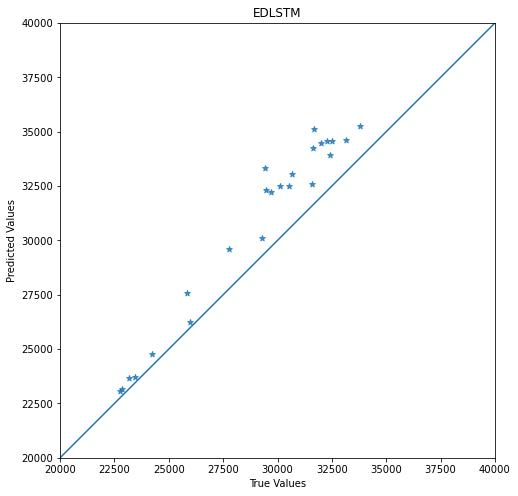

In [24]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")

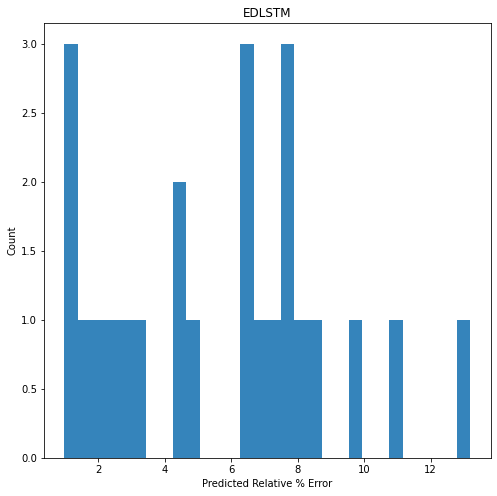

In [25]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [26]:
abs_error_ED_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_ED_LSTM)

5.663614256654166

In [27]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.68


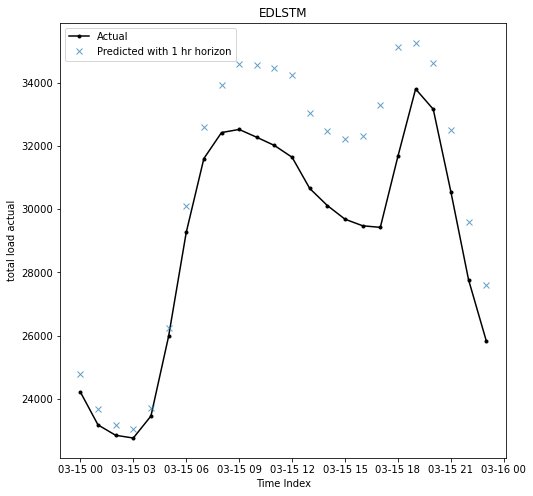

In [28]:
fig=plot_predictions(eval_df,1,modeltype,feature,f"./{modeltype}/predictions_{namespace}.png")

In [29]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [30]:
def make_twoweek_predictions(idx_test,data_y_test0,data_x_test):
    idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
    y_test_filtered2 = data_y_test0.loc[idx_prediction]
    df_pred =pd.DataFrame(index=y_test_filtered2.index)
        
    for i in range(len(data_x_test)):
        case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
        date_range = pd.date_range(start=idx_test[i],freq='h',periods=24)
        Y_test_predictions = pd.Series(best_models.predict(case_test).flatten(),index=date_range)
        df_pred[f'pred_{i}'] = Y_test_predictions
        
    df_pred['mean'] = df_pred.mean(axis=1)
    df_pred['Actual'] = y_test_filtered2
    return df_pred

def calculate_r2_scores(df_pred):
    r2_list=[]
    for column in df_pred.columns:
        if column not in ['Actual','mean']:
            pred = df_pred[column].dropna()
            act = df_pred.loc[pred.index,'Actual']
            r2= r2_score(pred,act)
            r2_list.append(r2)
    return r2_list      
    
def plot_twoweek_predictions(df_pred,path,add_traces = False):
    mpl.rcParams['figure.figsize'] = [16, 8.0]
    fig,ax = plt.subplots(1)
    ax.plot(df_pred.index,df_pred['Actual'])
    ax.plot(df_pred.index,df_pred['mean'])
    if add_traces:
        for column in df_pred.columns:
            if column not in ['Actual','mean']:
                ax.plot(df_pred[column],'o')
    fig.savefig(path)
    return fig
    pass



In [31]:
df_pred = make_twoweek_predictions(idx_test=idx_test,data_y_test0=data_y_test0,data_x_test=data_x_test)

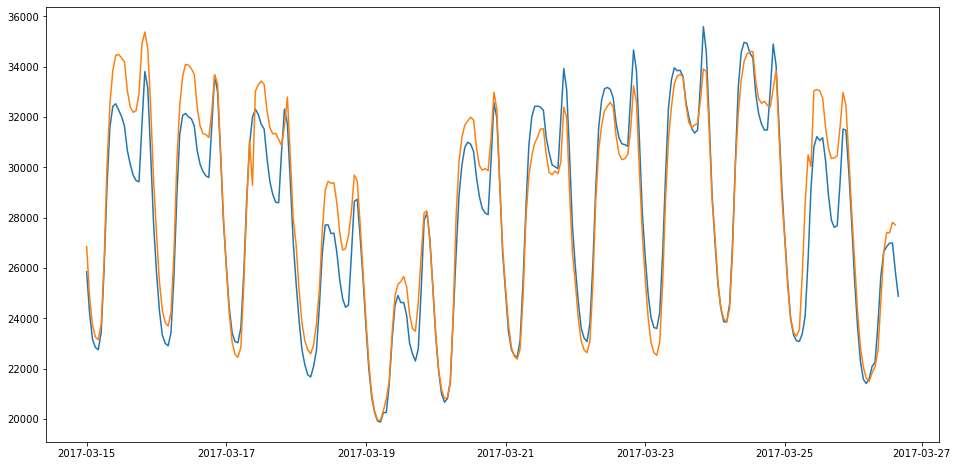

In [32]:
fig = plot_twoweek_predictions(df_pred,f'./{modeltype}/twoweek_predictions_{namespace}.png',add_traces=False)

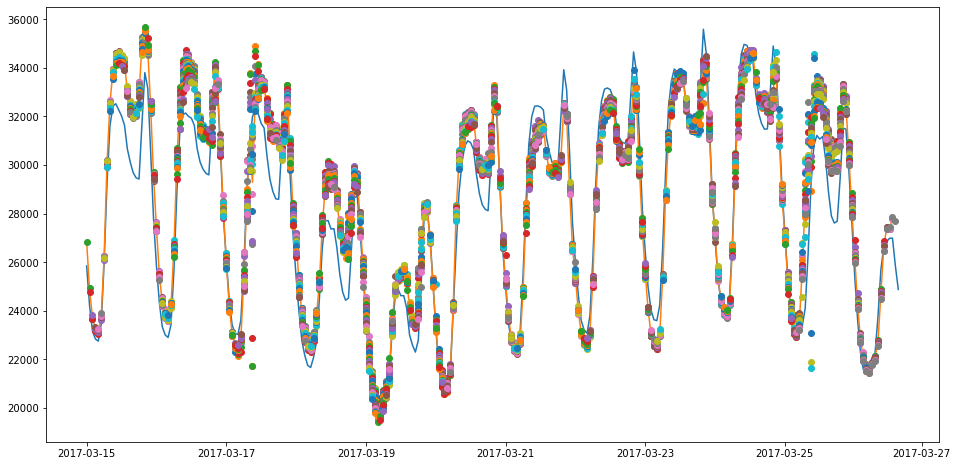

In [39]:
fig = plot_twoweek_predictions(df_pred,f'./{modeltype}/twoweek_predictions_{namespace}.png',add_traces=True)

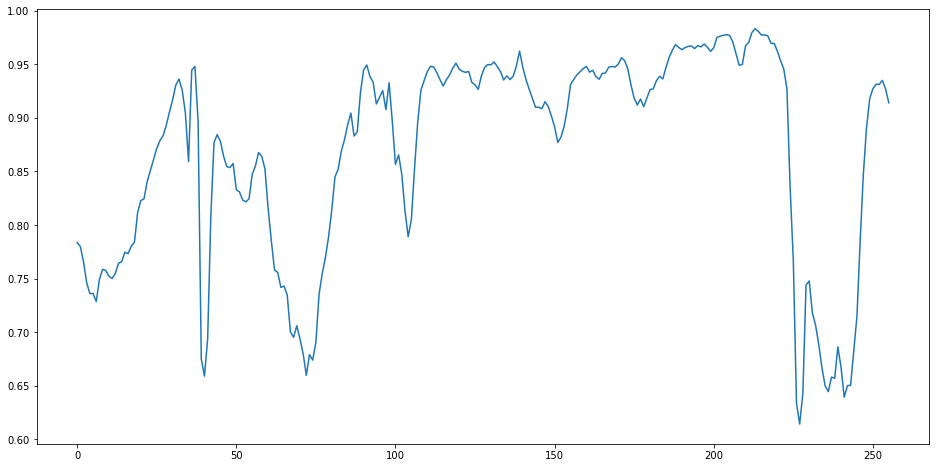

In [33]:
r2 = calculate_r2_scores(df_pred)
plt.figure()
plt.plot(r2)

In [34]:
sum(r2)/len(r2)

0.8687248586743254

In [35]:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.90


In [36]:
eval_df2 = create_eval_df(df_pred['mean'][:-1],y_test_filtered2[:-1])

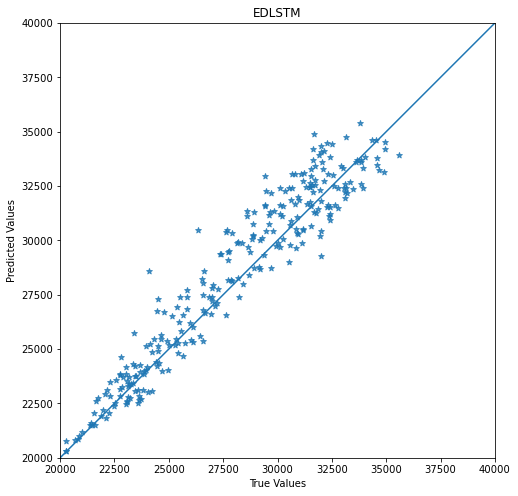

In [37]:
fig = plot_accuracy(eval_df2,modeltype,f"./{modeltype}/accuracy3_{namespace}.png")

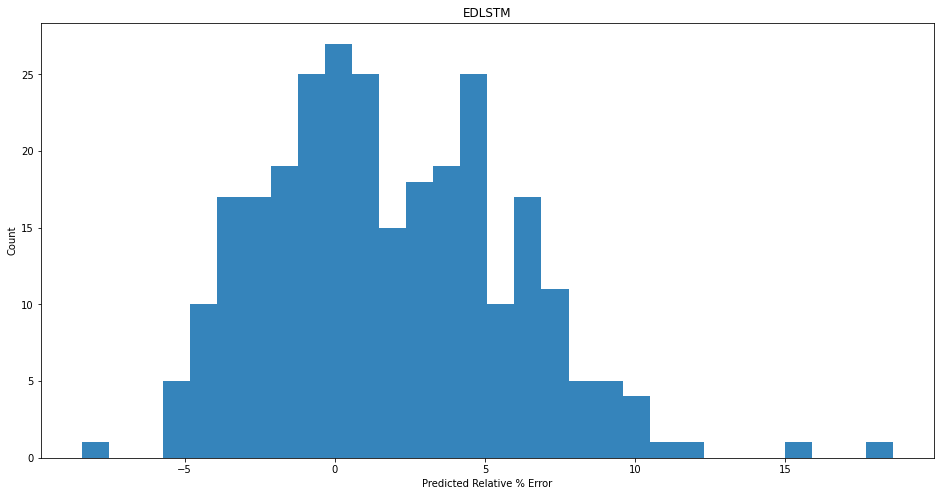

In [38]:
fig = plot_error_variations(eval_df2,modeltype,f"./{modeltype}/error_variations3_{namespace}.png")